In [4]:
import numpy as np
from scipy.stats import norm, beta

def clopper_pearson_interval(k:int, n:int, alpha:float=0.05) -> tuple[float, float]:
    lower_bound = beta.ppf(alpha / 2, k, n - k + 1) if k > 0 else 0.0
    upper_bound = beta.ppf(1 - alpha / 2, k + 1, n - k) if k < n else 1.0

    return (lower_bound, upper_bound)

def wilson_score_interval(k:int, n:int, alpha:float=0.05) -> tuple[float, float]:
    p_hat = k / n
    z = norm.ppf(1 - alpha / 2)
    denominator = 1 + (z**2 / n)
    center_adjusted_probability = p_hat + (z**2 / (2 * n))
    adjusted_standard_deviation = np.sqrt((p_hat * (1 - p_hat) + (z**2 / (4 * n))) / n)

    lower_bound = (center_adjusted_probability - z * adjusted_standard_deviation) / denominator
    upper_bound = (center_adjusted_probability + z * adjusted_standard_deviation) / denominator

    return (max(0.0, lower_bound), min(1.0, upper_bound))

def agresti_coull_interval(k:int, n:int, alpha:float=0.05) -> tuple[float, float]:
    z = norm.ppf(1 - alpha / 2)
    n_tilde = n + z**2
    p_tilde = (k + (z**2 / 2)) / n_tilde
    margin_of_error = z * np.sqrt((p_tilde * (1 - p_tilde)) / n_tilde)

    lower_bound = p_tilde - margin_of_error
    upper_bound = p_tilde + margin_of_error

    return (max(0.0, lower_bound), min(1.0, upper_bound))

def wald_interval(k:int, n:int, alpha:float=0.05) -> tuple[float, float]:
    p_hat = k / n
    z = norm.ppf(1 - alpha / 2)
    margin_of_error = z * np.sqrt((p_hat * (1 - p_hat)) / n)

    lower_bound = p_hat - margin_of_error
    upper_bound = p_hat + margin_of_error

    return (max(0.0, lower_bound), min(1.0, upper_bound))


def jeffreys_interval(k:int, n:int, alpha:float=0.05) -> tuple[float, float]:
    lower_bound = beta.ppf(alpha / 2, k + 0.5, n - k + 0.5) if k > 0 else 0.0
    upper_bound = beta.ppf(1 - alpha / 2, k + 0.5, n - k + 0.5) if k < n else 1.0

    return (lower_bound, upper_bound)

rng = np.random.default_rng(42)

p_list = rng.uniform(size=10000)
k = np.count_nonzero(p_list < 0.05)
n = len(p_list)
alpha = 0.05

print("Clopper-Pearson Interval:", clopper_pearson_interval(k, n, alpha))
print("Wilson Score Interval:", wilson_score_interval(k, n, alpha))
print("Agresti-Coull Interval:", agresti_coull_interval(k, n, alpha))
print("Wald Interval:", wald_interval(k, n, alpha))
print("Jeffreys Interval:", jeffreys_interval(k, n, alpha))
print()

lower, upper = clopper_pearson_interval(k, n, alpha)
print("Clopper-Pearson Interval:", upper - lower)
lower, upper = wilson_score_interval(k, n, alpha)
print("Wilson Score Interval:", upper - lower)
lower, upper = agresti_coull_interval(k, n, alpha)
print("Agresti-Coull Interval:", upper - lower)
lower, upper = wald_interval(k, n, alpha)
print("Wald Interval:", upper - lower)
lower, upper = jeffreys_interval(k, n, alpha)
print("Jeffreys Interval:", upper - lower)

Clopper-Pearson Interval: (0.0465774848780392, 0.05528648435623759)
Wilson Score Interval: (0.04666599590665272, 0.05527898822956312)
Agresti-Coull Interval: (0.04666254412446779, 0.055282440011748056)
Wald Interval: (0.046496133298994664, 0.05510386670100533)
Jeffreys Interval: (0.04662546620160906, 0.05523449574795311)

Clopper-Pearson Interval: 0.008708999478198393
Wilson Score Interval: 0.0086129923229104
Agresti-Coull Interval: 0.008619895887280266
Wald Interval: 0.008607733402010667
Jeffreys Interval: 0.00860902954634405


In [14]:
print(wilson_score_interval(0, 1000))

(2.1601063852437764e-19, 0.003826758485555124)


In [ ]:
from typing import Callable

def conduct(
    true_p: float,
    method: Callable,
    n: int,
    rng: np.random.Generator,
    alpha: float = 0.05,
    iter:int = 100_000
) -> tuple[bool, float, float]:
    p_list = rng.uniform(size=(n, iter))
    k_s = np.count_nonzero(p_list < true_p, axis=0)
    bool_list = []
    length_list = []
    for k in k_s:
        lower, upper = method(k, n, alpha)
        bool_list.append(lower <= true_p <= upper)
        length_list.append(upper - lower)
    return np.mean(bool_list), np.mean(length_list)

rng = np.random.default_rng(42)
print(conduct(0.05, clopper_pearson_interval, 1000, rng))

(10000,)
(0.9574, 0.027979840088065543)


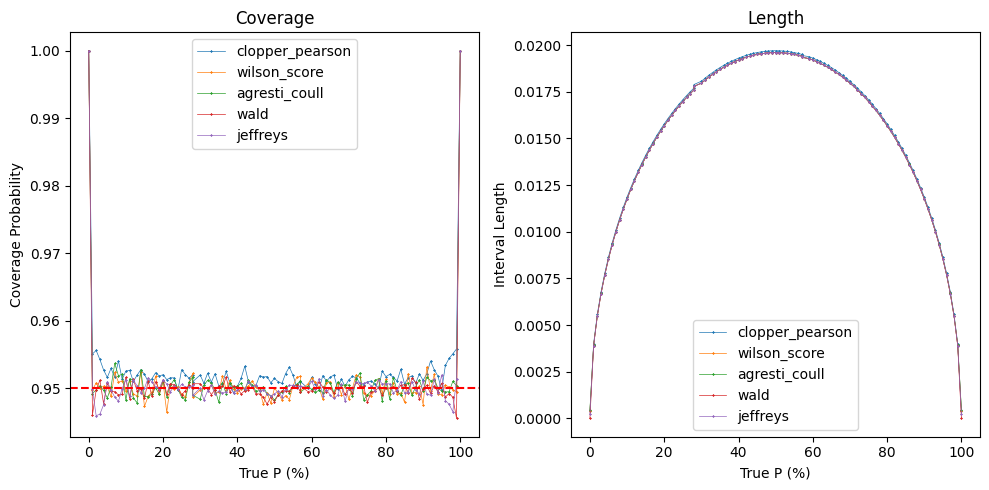

In [29]:
import polars as pl
import matplotlib.pyplot as plt

frame = pl.read_csv("ci_method_results.csv")
frame = frame.with_columns(
    (pl.col("true_p") * 100).cast(pl.Int32).alias("true_p")
)
frame = frame.filter(pl.col("n") == 10000)


methods = ["clopper_pearson", "wilson_score", "agresti_coull", "wald", "jeffreys"]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for method in methods:
    sub_frame = frame.filter(pl.col("method") == method).sort("true_p")
    coverage = sub_frame.select(pl.col("coverage")).to_series().to_list()
    length = sub_frame.select(pl.col("length")).to_series().to_list()
    true_p = sub_frame.select(pl.col("true_p")).to_series().to_list()


    ax[0].plot(true_p, coverage, marker="x", label=method, ms=1, lw=0.5)
    ax[1].plot(true_p, length, marker="x", label=method, ms=1, lw=0.5)

ax[0].axhline(y=0.95, color="r", linestyle="--")
# ax[0].set_ylim(0.94, 1.0)
ax[0].set_title("Coverage")
ax[0].set_xlabel("True P (%)")
ax[0].set_ylabel("Coverage Probability")
ax[0].legend()

ax[1].set_title("Length")
ax[1].set_xlabel("True P (%)")
ax[1].set_ylabel("Interval Length")
ax[1].legend()

plt.tight_layout()
plt.show()